<a href="https://colab.research.google.com/github/vitroid/TileCycles/blob/main/TileCycles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install genice to generate the structure of ice.
! pip install --index-url https://test.pypi.org/simple/ 'genice2>=2.1b9'

## benchmark test

In [5]:
from genice2.genice import GenIce
from genice2.plugin import Lattice, Format, Molecule

import networkx as nx
import numpy as np
import random
import time


# sampling parameters for benchmarking
# Accurate
maxRepeat = 100  # loops
maxAccum  = 25   # sec
maxProc   = 100  # sec
maxNode   = 1000000

# Rough estimate
# maxRepeat = 10  # loops
# maxAccum  = 5   # sec
# maxProc   = 10  # sec
# maxNode   = 100000

In [2]:
def test_icerule(d, N):
    assert d.number_of_nodes() == N
    for node in d:
        assert d.in_degree(node) == 2
        assert d.in_degree(node) == 2        

## Buch's algorithm

There are two hydrogen sites between two neighboring oxygens, and Buch's algorithm assumes that the initial configuration is one in which all the hydrogens randomly occupy one of the two sites.

In the initial configuration, there are many oxygen atoms with excess hydrogen. The algorithm migrates hydrogen from such an oxygen atom to a neighboring oxygen atom, and repeats the process randomly until there are two hydrogen species in every oxygen atom.


In [3]:
def migrate(d, excess):
    """
    excess is a set of nodes having more than two outgoing edges
    """
    while len(excess) > 0:
        # random choice from candidates;
        # there may be faster ways
        head = random.choice(list(excess))
        nexts = list(d.successors(head))
        next = random.choice(nexts)
        d.remove_edge(head, next)
        d.add_edge(next, head)
        # if head's outgoing order was three
        if len(nexts) == 3:
            # remove from the excess list
            excess.remove(head)
        # if next's outgoing orderis three
        if d.out_degree(next) == 3:
            # it becomes a new excess
            excess.add(next)

In [ ]:
lattice = Lattice("1c")
formatter = Format("raw", stage=(2,))  # generates an undirected graph

buch = []
lastN = 0
for NN in range(8, 100):
    N = int(1.4**(NN/3))
    if N == lastN:
        continue
    lastN = N
    raw = GenIce(lattice, rep=[N, N, N]).generate_ice(formatter)
    g = raw['graph']
    Nnode = g.number_of_nodes()

    delta = 0.0
    Nrep = 0
    while delta < maxAccum and Nrep < maxRepeat:
        dd = nx.DiGraph()
        for a, b in g.edges():
            if random.randint(0, 1) == 1:
                dd.add_edge(a, b)
            else:
                dd.add_edge(b, a)

        now = time.time()
        migrate(dd, set([x for x in dd.nodes if dd.out_degree(x) > 2]))
        delta += time.time() - now
        Nrep += 1
    delta /= Nrep
    buch.append([Nnode, delta, Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(dd, Nnode)
    if delta > maxProc:
        break
    if Nnode > maxNode:
        break

## GenIce algorithm

Tiling by cycles.

In [6]:
from collections import defaultdict


def find_cycle(g, chain, order):
    # head of the snake
    head = chain[-1]
    # neck is the vertex next to head
    neck = -1
    if len(chain) > 1:
        neck = chain[-2]
    while True:
        # candidates for the next step
        candids = [i for i in g[head] if i != neck]
        # go ahead
        neck = head
        head = random.choice(candids)
        # lookup the new head in the markers
        i = order[head]
        # if it is marked as the tail end of the snake,
        if i == 0:
            # the random walk returns to the first node of the chain;
            # unmark the head.
            order[head] = -1
            # return an empty chain and a cycle
            return [], chain
        # if the random walk crosses at an intermediate node of the chain,
        elif i > 0:
            # return a chain and a cycle
            return chain[:i+1], chain[i:]
        # otherwise, mark the new head position
        order[head] = len(chain)
        chain.append(head)


def remove_cycle(g, cycle, order):
    # unmark vertices in the cycle (except for the first vertecx)
    for i in range(1, len(cycle)):
        order[cycle[i]] = -1
    # remove edges of the cycle
    for i in range(len(cycle)):
        a = cycle[i-1]
        b = cycle[i]
        g.remove_edge(a, b)
    # remove edgeless vertices in the graph
    for a in cycle:
        if g.degree(a) == 0:
            g.remove_node(a)


def tileByCycles(g):
    # random walk path
    chain = []
    # markers that indicate the orders in the path
    order = -np.ones(g.number_of_nodes(), dtype=np.int)
    while g.number_of_nodes() > 0:
        # if the chain is empty
        if len(chain) == 0:
            # randomly select the "head" node.
            head = random.choice(list(g.nodes()))
            chain = [head]
            # mark it as the first node.
            order[head] = 0
        # walk randomly to find a cycle.
        chain, cycle = find_cycle(g, chain, order)
        # found.
        yield cycle
        # remove it from the graph and unmark.
        remove_cycle(g, cycle, order)

In [7]:
lattice = Lattice("1c")
formatter = Format("raw", stage=(2,))  # generates an undirected graph

gen = []
for NN in range(4, 100):
    N = int(2**(NN/3))
    raw = GenIce(lattice, rep=[N, N, N]).generate_ice(formatter)
    g0 = raw['graph']
    Nnode = g0.number_of_nodes()

    delta = 0.0
    Nrep = 0
    while delta < maxAccum and Nrep < maxRepeat:
        g = nx.Graph(g0)

        now = time.time()
        dd = nx.DiGraph()
        for cycle in tileByCycles(g):
            nx.add_cycle(dd, cycle)
        delta += time.time() - now
        Nrep += 1
    delta /= Nrep
    gen.append([Nnode, delta, Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(dd, Nnode)
    if Nnode >= maxNode:
        break

64 molecules 0.0011054754257202148 s avg. 10 reps.
216 molecules 0.002221560478210449 s avg. 10 reps.
512 molecules 0.003977227210998535 s avg. 10 reps.
1000 molecules 0.007809114456176758 s avg. 10 reps.
1728 molecules 0.015598368644714356 s avg. 10 reps.
4096 molecules 0.03353116512298584 s avg. 10 reps.
8000 molecules 0.06730248928070068 s avg. 10 reps.
13824 molecules 0.12879233360290526 s avg. 10 reps.
32768 molecules 0.3576754808425903 s avg. 10 reps.
64000 molecules 0.7928772653852191 s avg. 7 reps.
125000 molecules 1.6485790014266968 s avg. 4 reps.


## Rahman's algorithm

The algorithm prepares a depolarized structure in advance and generates a hydrogen-disordered structure by successively reversing randomly chosen homodromic cycles.

Here, the ice Ic structure generated by GenIce is used as an initial structure, and the procedure is repeated until all the edges are inverted at least once.

In [ ]:
import random


def six(d, Nnode):
    """
    find a cyclic path in the given digraph.
    d: digraph (networkx.DiGraph)
    """
    head = random.randint(0, Nnode-1)
    path = [head]
    while True:
        nexts = list(d.neighbors(head))
        next = random.choice(nexts)
        if next in path:
            i = path.index(next)
            return path[i:]
        path.append(next)
        head = next


def invertCycle(d, cycle, g):
    for i in range(len(cycle)):
        a, b = cycle[i-1], cycle[i]
        d.remove_edge(a, b)
        d.add_edge(b, a)
        # footprint
        if g.has_edge(a, b):
            g.remove_edge(a, b)

In [ ]:
lattice = Lattice("1c")
formatter = Format("raw", stage=(3,))  # We need the directed graph of ice!

rahman = []
for N in range(1, 20):
    raw = GenIce(lattice, rep=[N, N, N]).generate_ice(formatter)
    d = nx.DiGraph(raw['digraph'].edges())
    Nnode = d.number_of_nodes()

    delta = 0.0
    Nrep = 0
    while delta < maxAccum and Nrep < maxRepeat:
        # footprint
        g = nx.Graph(d)

        now = time.time()
        while g.number_of_edges() > 0:
            cycle = six(d, d.number_of_nodes())
            invertCycle(d, cycle, g)
        delta += time.time() - now
        Nrep += 1
    delta /= Nrep
    rahman.append([Nnode, delta, Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(d, Nnode)
    if delta > maxProc:
        break

In [ ]:
from matplotlib import pyplot as plt


buch = np.array(buch)
gen = np.array(gen)
rahman = np.array(rahman)


fig1, ax = plt.subplots()

# ax.set_aspect('square') #, adjustable='box')

plt.plot(rahman[:, 0], rahman[:, 1], label="Rahman")
plt.plot(buch[:, 0], buch[:, 1], label="Buch")
plt.plot(gen[:, 0], gen[:, 1], label="This work")
plt.xlim(0, 130000)
plt.legend()
plt.xlabel("Number of molecules")
plt.ylabel("Time / s")
plt.ylim(0, 100)
plt.show()

fig1.savefig("benchmark.pdf")

In [ ]:
fig1, ax = plt.subplots()

lin = np.linspace(1e2, 1e5, 100)
plt.loglog(rahman[:, 0], rahman[:, 1], label="Rahman")
plt.loglog(buch[:, 0], buch[:, 1], label="Buch")
plt.loglog(gen[:, 0], gen[:, 1], label="This work")
plt.loglog(lin, lin*1e-5, label=r"y=A x")
plt.legend()
plt.xlabel("Number of molecules")
plt.ylabel("Time / s")

fig1.savefig("benchmark-loglog.pdf")


In [ ]:
# for TOC graphics

from matplotlib import pyplot as plt


# make a 2D 6x6 ice.
def draw_cycle(cycle, pos, N, col):
    threshold = 1.1/N**2
    cm = plt.get_cmap('rainbow')
    for i in range(len(cycle)):
        a = cycle[i-1]
        b = cycle[i]
        va = pos[a]
        vb = pos[b]
        d = vb - va
        if d@d > threshold:
            d -= np.floor(d+0.5)
            seg = np.vstack([vb-d, vb])
            plt.plot(seg[:, 0], seg[:, 1], color=cm(col))
        seg = np.vstack([va, va+d])
        plt.plot(seg[:, 0], seg[:, 1], color=cm(col))


N = 8
X = np.arange(N)
Y = np.arange(N)
X, Y = np.meshgrid(X, Y)
X = X.reshape(N * N)
Y = Y.reshape(N * N)
pos = np.vstack([X, Y]).T / N  # fractional coordinate
g = nx.Graph()
for a in range(N*N):
    for b in range(a):
        d = pos[a] - pos[b]
        d -= np.floor(d+0.5)
        if (d@d)*N*N < 1.1:
            g.add_edge(a, b)

print(g.number_of_edges())


fig1, ax = plt.subplots()

cycles = []
dd = nx.DiGraph()
for cycle in tileByCycles(g):
    cycles.append(cycle)

for i, cycle in enumerate(cycles):
    draw_cycle(cycle, pos, N, i/len(cycles))

ax.set_aspect('equal', adjustable='box')
plt.show()
fig1.savefig("map.pdf", bbox='tight')

In [ ]:
!pip install tilecycles

In [8]:
# C++ implementation

import tilecycles_c as tc
import numpy as np

lattice = Lattice("1c")
formatter = Format("raw", stage=(2,))  # generates an undirected graph

seed = 1111

cpp = []
for NN in range(4, 100):
    N = int(2**(NN/3))
    raw = GenIce(lattice, rep=[N, N, N]).generate_ice(formatter)
    g0 = raw['graph']
    Nnode = g0.number_of_nodes()

    pairs = np.array([(i, j) for i, j in g0.edges()], dtype=np.int32)

    delta = 0.0
    Nrep = 0
    while delta < maxAccum and Nrep < maxRepeat:
        now = time.time()
        dd = nx.DiGraph()
        for cycle in tc.tile(pairs, Nnode, seed):
            nx.add_cycle(dd, cycle)
        delta += time.time() - now
        Nrep += 1
    delta /= Nrep
    cpp.append([Nnode, delta, Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(dd, Nnode)
    if Nnode >= maxNode:
        break

64 molecules 0.0084136962890625 s avg. 10 reps.
216 molecules 0.0004415273666381836 s avg. 10 reps.
512 molecules 0.0009991884231567382 s avg. 10 reps.
1000 molecules 0.0019438028335571288 s avg. 10 reps.
1728 molecules 0.003788447380065918 s avg. 10 reps.
4096 molecules 0.00989081859588623 s avg. 10 reps.
8000 molecules 0.024692177772521973 s avg. 10 reps.
13824 molecules 0.04694764614105225 s avg. 10 reps.
32768 molecules 0.12904930114746094 s avg. 10 reps.
64000 molecules 0.2868978261947632 s avg. 10 reps.
125000 molecules 0.642167717218399 s avg. 8 reps.


The C++ implementation is not quite fast because the data conversion between python always take a linear time against the system size.

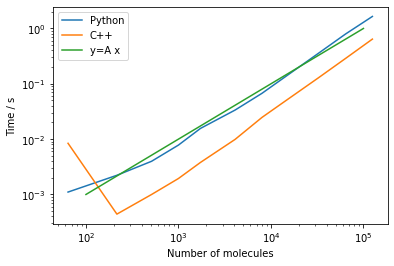

In [9]:
from matplotlib import pyplot as plt


gen = np.array(gen)
cpp = np.array(cpp)


fig1, ax = plt.subplots()

lin = np.linspace(1e2, 1e5, 100)
plt.loglog(gen[:, 0], gen[:, 1], label="Python")
plt.loglog(cpp[:, 0], cpp[:, 1], label="C++")

plt.loglog(lin, lin*1e-5, label=r"y=A x")
plt.legend()
plt.xlabel("Number of molecules")
plt.ylabel("Time / s")

fig1.savefig("benchmark-cp-loglog.pdf")

# C++ is four times faster than python,
# but Python is fast enough...

## 検定

生成した氷の構造が十分にランダムであるかどうかを確認するために、サイクルを構成する水素結合の向きの統計をとる。

氷の結晶構造はさまざまなサイズのirreducible ringsで構成されている。氷Iは6員環のみで構成されている。アイスルールを満たすネットワークに含まれる1つの6員環に注目すると、それを構成する水素結合の配向パターンには統計的な特徴がある。ここでは計算を簡単にするために次のようなBethe tree 近似を導入する。ある4-connectedな無限無向グラフ$g$が、6-cycleを1つだけもち、ほかにはサイクルを持たないものとする。このグラフ$g$にアイスルールを導入して有向グラフに変換した時、6-cycleに沿った辺の配向パターンの分布は表1のようになる。(誰かすでにやってそうなものだ。Stillinger?)

*Table 1 アイスルールを満たす有向グラフの六員環の配向パターンと、Bethe tree近似による出現確率*

| pattern| probability|
|------|--------|
|→→→→→→| 64/365 |
|→→→→→←| 96/365 |
|→→→→←←| 96/365 |
|→→→←→←| 24/365 |
|→→→←←←| 48/365 |
|→→←→→←| 12/365 |
|→→←→←←| 24/365 |
|→←→←→←|  1/365 |

現実の氷には無数の六員環が含まれているが、均質にランダムな水素無秩序氷では、上の分布に極めて近い分布が得られる。そこで、表1の分布と、生成した氷構造での配向パターンの分布を比較し、それらの分布の間のKullback-Leibler divergence $d_{KL}$を、氷構造の均質さの尺度とみなす。均質にランダムな水素無秩序氷では、$d_{KL}$は0に近付くが、配向パターンに偏りがあると、より大きな値になる。

Rahmanらのアルゴリズムと、Buchらのアルゴリズムはどちらも収束的なアルゴリズムで、計算サイクルを増やすほど均質な分布に近付く。Rahmanらのアルゴリズムに関しては、初期配置を氷XI構造とする。また、Buchのアルゴリズムでは、初期配置はice ruleを満たさない完全ランダムな有向グラフとする。そして、ステップを重ねるごとに、上の分布にどのように近接するかを観察する。


## Test

To check whether the structure of the generated ice is sufficiently random, we take the statistics of the orientation of the hydrogen bonds that make up the cycle.

The crystal structure of ice consists of irreducible rings of various sizes. Ice I consists of only six-membered rings. If we focus on a single six-membered ring in the network that satisfies the ice rules, the orientation pattern of the hydrogen bonds that make up the ring has a statistical characteristic. To simplify the calculation, we introduce the following Bethe tree approximation. Suppose that a 4-connected infinite undirected graph $g$ has only one 6-cycle and no other cycles. When this graph $g$ is transformed into a directed graph by introducing the ice rules, the distribution of  edge orientation patterns along the 6-cycle is as shown in Table 1.

*Table 1 Orientation patterns of six-membered rings in directed graphs satisfying the ice rules and their probability of occurrence using the Bethe tree approximation*.

| pattern| probability|
|------|--------|
|→→→→→→| 64/365 |
|→→→→→←| 96/365 |
|→→→→←←| 96/365 |
|→→→←→←| 24/365 |
|→→→←←←| 48/365 |
|→→←→→←| 12/365 |
|→→←→←←| 24/365 |
|→←→←→←|  1/365 |

Although real ice contains innumerable six-membered rings, homogeneously random hydrogen-disordered ice yields a distribution very close to the above one. Therefore, we compare the distributions in Table 1 with the distributions of the orientation patterns in the generated ice structure, and consider the Kullback-Leibler divergence $d_{KL}$ between these distributions as a measure of the homogeneity of the ice structure. For homogeneously random hydrogen-disordered ice, $d_{KL}$ approaches zero, while biases in the orientation pattern lead to larger values.

Both Rahman et al.'s and Buch et al.'s algorithms are convergent algorithms, approaching a homogeneous distribution with increasing number of computational cycles. For Rahman et al.'s algorithm, we choose the ice XI structure as the initial configuration. For Buch's algorithm, the initial configuration is a completely random directed graph that does not satisfy the ice rules. Then, with each step, we observe how it approaches the distribution above.

In [ ]:
# Taken from GenIce/_ringstat.py
from genice2.formats._ringstat import probabilities, orientations, encode


def KLdiv(d, pos):
    graph = nx.Graph(d)  # undirected
    prob = probabilities(6)
    stat = defaultdict(int)

    for ring in cycles_iter(graph, 6,  pos=pos):
        ori = orientations(ring, d)
        c   = encode(ori)
        n   = len(ring)
        stat[c] += 1

    #size code code(binary) Approx. Stat.
    denom = 0
    for c in stat:
        denom += stat[c]
    dKL = 0.0
    for c in prob:
        q = stat[c]/denom
        p = prob[c]
        if q > 0.0:
            dKL += q*(log(q) - log(p))
    dKL /= log(2.0)  #bit
    return dKL

In [ ]:
# Rahman's

lattice = Lattice("11")
formatter = Format("raw", stage=(1,3,))

N = 8
raw = GenIce(lattice, rep=[N, N, N]).generate_ice(formatter)
d = nx.DiGraph(raw['digraph'].edges())
Nnode = d.number_of_nodes()
rpos = raw['reppositions']

# footprint
g = nx.Graph(d)

steps = 0
watch = 1
rahman_conv = []
while g.number_of_edges() > 0:
    steps += 1
    if watch == steps:
        # ring stat
        dKL = KLdiv(d, rpos)
        print(steps, dKL)
        rahman_conv.append([steps, dKL])
        # next watch interval
        watch += 100  # watch

    cycle = six(d, d.number_of_nodes())
    invertCycle(d, cycle, g)

dKL = KLdiv(d, rpos)
print(steps, dKL)
rahman_conv.append([steps, dKL])


In [ ]:
# Buch's

buch_conv = []

def migrate2(d, excess):
    """
    excess is a set of nodes having more than two outgoing edges
    """
    steps = 0
    watch = 1
    while len(excess) > 0:
        steps += 1
        if watch <= steps:
            # ring stat
            dKL = KLdiv(d, rpos)
            print(steps, dKL)
            buch_conv.append([steps, dKL])
            # next watch interval
            watch += 1000  # watch / 2

        head = random.choice(list(excess))
        nexts = list(d.successors(head))
        next = random.choice(nexts)
        d.remove_edge(head, next)
        d.add_edge(next, head)
        # if head's outgoing order was three
        if len(nexts) == 3:
            # remove from the excess list
            excess.remove(head)
        # if next's outgoing orderis three
        if d.out_degree(next) == 3:
            # it becomes a new excess
            excess.add(next)
    dKL = KLdiv(d, rpos)
    print(steps, dKL)
    buch_conv.append([steps, dKL])


lattice = Lattice("1h")
formatter = Format("raw", stage=(1,2,))  # generates an undirected graph
water = Molecule("spce")


N = 8
raw = GenIce(lattice, rep=[N, N, N]).generate_ice(water, formatter)
g = raw['graph']
rpos = raw['reppositions']
Nnode = g.number_of_nodes()

dd = nx.DiGraph()
for a, b in g.edges():
    if random.randint(0, 1) == 1:
        dd.add_edge(a, b)
    else:
        dd.add_edge(b, a)

migrate2(dd, set([x for x in dd.nodes if dd.out_degree(x) > 2]))


In [ ]:
# GenIce's

lattice = Lattice("1h")
formatter = Format("raw", stage=(1,2,))  # generates an undirected graph
water = Molecule("spce")
N=8
raw = GenIce(lattice, rep=[N, N, N]).generate_ice(water, formatter)
g = nx.Graph(raw['graph'])
print(raw)
rpos = raw['reppositions']

d = nx.DiGraph()
for cycle in tileByCycles(g):
    nx.add_cycle(d, cycle)

genice_dKL = KLdiv(d, rpos)
print(genice_dKL)


In [ ]:
from matplotlib import pyplot as plt


buch_conv = np.array(buch_conv)
rahman_conv = np.array(rahman_conv)

fig1, ax = plt.subplots()

lin = np.linspace(1e2, 1e5, 100)
plt.plot(rahman_conv[:, 0] / rahman_conv[-1, 0]*100, rahman_conv[:, 1], label="Rahman")
plt.plot(buch_conv[:, 0] / buch_conv[-1, 0]*100, buch_conv[:, 1], label="Buch")
plt.plot(100, genice_dKL, 'o', label="This work")
plt.yscale('log')
plt.legend()
plt.xlabel("Progress (%)")
plt.ylabel(r"$d_\mathrm{KL}$")

fig1.savefig("ringstat-log.pdf")

In [ ]:
!pip install pycodestyle flake8 pycodestyle_magic

In [ ]:
%load_ext pycodestyle_magic